In [1]:
# pip install pandas_market_calendars

In [2]:
# pip install yfinance

In [3]:
import pandas as pd
import numpy as np
from datetime import date
import datetime
import yfinance as yf
from tqdm import tqdm
import statistics
from sklearn.covariance import LedoitWolf
import pandas_market_calendars as mcal
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', None)

### Get dates

In [4]:
# today = datetime.datetime.strptime('2021-05-10', '%Y-%m-%d').date()
today = datetime.datetime.now().date()

nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date = today + datetime.timedelta(days = -15), end_date = today).index.tolist()
yesterday = early[-2].date()
fivedaysbefore = early[-5].date()
today = early[-1].date()

print(today, yesterday, fivedaysbefore)

2021-05-26 2021-05-25 2021-05-20


In [5]:
# market_close_time = datetime.datetime.strptime(today.strftime('%Y-%m-%d') + ' 01:00:00', '%Y-%m-%d %H:%M:%S')
market_close_time = datetime.datetime.strptime('1:00PM', '%I:%M%p').time()
market_close_time

datetime.time(13, 0)

## Read Nasdaq tickers

In [6]:
raw = pd.read_csv('ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt', sep = '|')
raw['Financial Status'] = raw['Financial Status'].fillna('N')
data = raw[(raw.Symbol.notnull()) & (raw['Financial Status'] == 'N')]

data = data[~data['Security Name'].str.contains('ADS')]
data = data[~data['Security Name'].str.contains('S.A')]
data = data[~data['Security Name'].str.lower().str.contains('depositary')]
data = data[~data['Security Name'].str.lower().str.contains('depository')]

# data = data[~((data.ETF == 'Y') & (data['Market Category'] != 'G'))]
data = data[data['Test Issue'] != 'Y']
data = data[data['Round Lot Size'] == 100]
print(data.shape)

(9968, 12)


In [7]:
symbols = [i for i in data.Symbol if '$' not in i]
symbols = [i for i in symbols if '.' not in i]

In [8]:
# symbols = symbols[:100]

In [9]:
data = data[data.Symbol.isin(symbols)]

In [10]:
len(symbols)

9152

### Get Stock Prices from Yahoo and Prep Data

In [17]:
final_symbols = symbols #pd.read_csv('final_stocks.csv')['0'].to_list()
len(final_symbols)

9152

### Get Actual Data

In [18]:
from tiingo import TiingoClient

config = {}

config['session'] = True

config['api_key'] = "your-api-key"

client = TiingoClient(config)

In [19]:
supported = pd.read_csv('https://apimedia.tiingo.com/docs/tiingo/daily/supported_tickers.zip').dropna()
supported['startDate'] = pd.to_datetime(supported['startDate'], format = '%Y-%m-%d').dt.date
supported['endDate'] = pd.to_datetime(supported['endDate'], format = '%Y-%m-%d').dt.date
# supported = supported[supported.exchange.isin(['NYSE','NASDAQ','AMEX'])]

In [20]:
# supported = supported[supported.assetType.isin(['ETF'])]
supported = supported[supported.priceCurrency.isin(['USD'])]
supported = supported[~supported.exchange.isin(['PINK'])]
supported = supported[~supported.assetType.isin(['Mutual Fund','ETF'])]

In [21]:
oneyearbefore = today + datetime.timedelta(days = -365)
supported = supported[supported.endDate >= yesterday]
supported = supported[supported.startDate <= oneyearbefore]
oneyearbefore

datetime.date(2020, 5, 26)

In [22]:
supported

,ticker,exchange,assetType,priceCurrency,startDate,endDate
3752,601066,SHG,Stock,USD,2018-06-20,2021-05-25
3774,601138,SHG,Stock,USD,2018-06-08,2021-05-25
3814,601319,SHG,Stock,USD,2018-11-16,2021-05-25
4518,900901,SHG,Stock,USD,2007-01-04,2021-05-25
4519,900902,SHG,Stock,USD,2007-01-04,2021-05-25
...,...,...,...,...,...,...
94364,ZYME,NYSE,Stock,USD,2017-04-28,2021-05-25
94365,ZYNE,NASDAQ,Stock,USD,2015-08-05,2021-05-25
94369,ZYXI,NASDAQ,Stock,USD,2002-12-31,2021-05-25
94375,ZZLL,OTCQB,Stock,USD,2017-09-26,2021-05-25


In [23]:
supported.groupby(['assetType','exchange']).count()

ticker  priceCurrency  startDate  endDate
assetType exchange                                            
Stock     AMEX            3              3          3        3
          BATS            4              4          4        4
          EXPM            6              6          6        6
          LSE             1              1          1        1
          NASDAQ       2948           2948       2948     2948
          NYSE         2441           2441       2441     2441
          NYSE ARCA      25             25         25       25
          NYSE MKT      232            232        232      232
          OTCBB           1              1          1        1
          OTCCE        1016           1016       1016     1016
          OTCGREY      2243           2243       2243     2243
          OTCMKTS        59             59         59       59
          OTCQB         895            895        895      895
          OTCQX         501            501        501      501
          SHG            50             50         50       50

In [24]:
supp_list = supported.ticker.tolist()

In [25]:
supp_list = [i for i in supp_list if '-' not in i]
len(supp_list)

9906

#### Check Webull Supported

In [26]:
available_tickers = [i for i in final_symbols if i in supp_list]
len(available_tickers)

4672

#### Get Volume

In [27]:
vol_hist = {}
vol_failed = []

for i in tqdm(supp_list):
    try:
        vol_hist[i] = client.get_dataframe(i,
                                              frequency='daily',
                                              metric_name='volume',
                                              startDate=fivedaysbefore,
                                              endDate=today).mean()
    except:
        vol_failed.append(i)

100%|██████████| 9906/9906 [35:27<00:00,  4.66it/s]  


In [28]:
vol_lst = [[i, j] for i, j in vol_hist.items()]
vol_df = pd.DataFrame(np.vstack(vol_lst))
vol_df.columns = ['Symbol','AvgVolume']
vol_df['AvgVolume'] = vol_df['AvgVolume'].astype(np.float)
vol_df['1stPerc'] = vol_df.AvgVolume.quantile(0.50)
vol_df['2ndPerc'] = vol_df.AvgVolume.quantile(0.95)
# vol_df = vol_df[(vol_df.AvgVolume >= 1e+5) & (vol_df.AvgVolume <= vol_df['2ndPerc'])]
vol_df = vol_df[(vol_df.AvgVolume >= vol_df['1stPerc']) & (vol_df.AvgVolume <= vol_df['2ndPerc'])]
vol_df.head()

,Symbol,AvgVolume,1stPerc,2ndPerc
3,900901,226486.0,50517.25,3355407.85
4,900902,358846.0,50517.25,3355407.85
5,900903,404462.0,50517.25,3355407.85
6,900904,627116.0,50517.25,3355407.85
7,900905,287698.0,50517.25,3355407.85


In [29]:
med_vol_tickers = vol_df.Symbol.drop_duplicates().tolist()

In [30]:
len(med_vol_tickers)

4455

#### Get Close

In [31]:
ticker_history = {}
failed = []

for i in tqdm(med_vol_tickers):
    try:
        ticker_history[i] = client.get_ticker_price(i,
                                              frequency='1Min',
                                              startDate=fivedaysbefore,
                                              endDate=today)
    except:
        print(f'No Data for {i}')
        failed.append(i)

100%|██████████| 4455/4455 [19:00<00:00,  3.91it/s]


In [32]:
lst = list(ticker_history.keys())

In [33]:
all_vals = []

for i in tqdm(lst):
    temp_df = pd.DataFrame(ticker_history[i])
    temp_df['high'] = i
    all_vals.append(temp_df.to_numpy())
    del temp_df

100%|██████████| 4455/4455 [00:42<00:00, 104.72it/s]


In [34]:
shortlisted = [i for i in all_vals if i.shape[0] > 1]

In [35]:
final_df = pd.DataFrame(np.vstack(shortlisted))
final_df.columns = ['DateTime','Close','Ticker','Low','Open']
final_df['Close'] = final_df['Close'].astype(np.float)
final_df['DateTime'] = pd.to_datetime(final_df['DateTime'])
final_df = final_df[['Ticker','DateTime','Close']]

In [36]:
final_df.groupby('Ticker')['Close'].count().describe()

count    3655.000000
mean     1867.486457
std       160.986040
min         2.000000
25%      1896.000000
50%      1905.000000
75%      1912.000000
max      1922.000000
Name: Close, dtype: float64

In [37]:
min_obs = final_df.groupby('Ticker')['Close'].count().quantile(0.25) #final_df.groupby('Ticker')['Close'].count().describe()['25%']
print(min_obs)

1896.0


In [38]:
final_df['n'] = final_df.groupby('Ticker')['Close'].transform('size')
final_df = final_df[final_df.n >= min_obs]

In [39]:
del final_df['n']

In [40]:
final_df_pivot = final_df.pivot(index = 'Ticker', columns = 'DateTime', values = 'Close').reset_index()

In [41]:
final_df_melt = final_df_pivot.melt(id_vars = 'Ticker')

In [42]:
final_df_melt['Date'] = final_df_melt['DateTime'].dt.date

In [43]:
final_df_melt.sort_values(['Ticker','DateTime'], inplace = True)

In [44]:
final_df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5335472 entries, 0 to 5335471
Data columns (total 4 columns):
 #   Column    Dtype              
---  ------    -----              
 0   Ticker    object             
 1   DateTime  datetime64[ns, UTC]
 2   value     float64            
 3   Date      object             
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 203.5+ MB


In [45]:
final_df.to_pickle('final_df.pkl')

In [46]:
# yahoo = pd.read_pickle('yahoo_data_today.pkl')

In [47]:
final_df_melt.groupby('Date')['value'].apply(lambda x: x.notnull().sum())

Date
2021-05-20    1079660
2021-05-21    1085416
2021-05-24    1085416
2021-05-25    1085416
2021-05-26     962409
Name: value, dtype: int64

In [48]:
final_df_melt.Ticker.drop_duplicates().size

2776

#### Merge

In [53]:
melted = final_df_melt.copy()

In [54]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5335472 entries, 0 to 5335471
Data columns (total 4 columns):
 #   Column    Dtype              
---  ------    -----              
 0   Ticker    object             
 1   DateTime  datetime64[ns, UTC]
 2   value     float64            
 3   Date      object             
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 203.5+ MB


In [55]:
melted.shape

(5335472, 4)

In [56]:
melted.columns = ['Symbol','DateTime','Close','Date']
melted.sort_values(['Symbol','DateTime'], inplace = True)

In [57]:
melted['Close'] = melted.groupby(['Symbol','Date'])['Close'].ffill()

In [58]:
melted['Close'] = melted.groupby(['Symbol','Date'])['Close'].bfill()

In [59]:
null_stocks = melted[melted.Close.isnull()].Symbol.drop_duplicates().tolist()
melted = melted[~melted.Symbol.isin(null_stocks)]

In [60]:
melted['DayClose'] = melted.groupby(['Symbol','Date'])['Close'].transform('last')

In [61]:
melted.head()

,Symbol,DateTime,Close,Date,DayClose
0,A,2021-05-20 13:30:00+00:00,131.090,2021-05-20,132.145
2776,A,2021-05-20 13:31:00+00:00,131.090,2021-05-20,132.145
5552,A,2021-05-20 13:32:00+00:00,131.095,2021-05-20,132.145
8328,A,2021-05-20 13:33:00+00:00,131.150,2021-05-20,132.145
11104,A,2021-05-20 13:34:00+00:00,131.350,2021-05-20,132.145


In [62]:
print(melted.Symbol.drop_duplicates().shape[0])

2776


In [63]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5335472 entries, 0 to 5335471
Data columns (total 5 columns):
 #   Column    Dtype              
---  ------    -----              
 0   Symbol    object             
 1   DateTime  datetime64[ns, UTC]
 2   Close     float64            
 3   Date      object             
 4   DayClose  float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 244.2+ MB


### Get Returns

In [64]:
returns = melted[melted.Date.isin([today, yesterday])]

In [65]:
returns = returns[['Symbol','Date','DayClose']].drop_duplicates().pivot(index = 'Symbol', columns = 'Date').reset_index()

In [66]:
returns.columns = ['Symbol','yesterday_close','today_close']

In [67]:
returns = returns[returns.yesterday_close != returns.today_close]

In [68]:
print('Stocks with valid data')
print(len(returns.Symbol))

Stocks with valid data
2761


In [69]:
returns['ret'] = returns['today_close'] / returns['yesterday_close'] - 1
returns['10thPerc'] = returns['ret'].quantile(0.10)
returns['90thPerc'] = returns['ret'].quantile(0.90)

In [70]:
assert returns['10thPerc'].unique()[0] != 0, '25th Percentile is zero, somethings not right'
assert returns['90thPerc'].unique()[0] != 0, '95th Percentile is zero, somethings not right'

In [71]:
returns = returns[(returns['ret'] >= returns['10thPerc']) & (returns['ret'] <= returns['90thPerc']) & (returns['today_close'] <= 100) & (returns['today_close'] >= 5)]

In [72]:
return_stocks = returns.Symbol.drop_duplicates().tolist()
len(return_stocks)

1604

<AxesSubplot:>

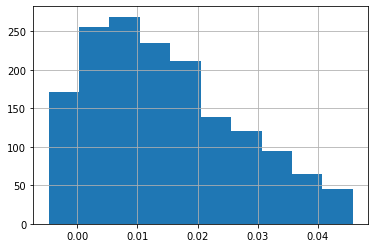

In [73]:
returns.ret.hist()

In [74]:
returns[returns.yesterday_close != returns.today_close]

,Symbol,yesterday_close,today_close,ret,10thPerc,90thPerc
3,AAT,35.150,35.800,0.018492,-0.00479,0.045829
4,AAWW,73.260,74.785,0.020816,-0.00479,0.045829
5,AB,43.770,44.155,0.008796,-0.00479,0.045829
6,ABB,33.675,33.760,0.002524,-0.00479,0.045829
8,ABCB,53.210,54.220,0.018981,-0.00479,0.045829
...,...,...,...,...,...,...
2770,ZUO,14.780,15.070,0.019621,-0.00479,0.045829
2772,ZVZZT,10.030,10.020,-0.000997,-0.00479,0.045829
2773,ZYME,28.660,29.205,0.019016,-0.00479,0.045829
2774,ZYNE,4.960,5.175,0.043347,-0.00479,0.045829


### Covariance

In [75]:
cov = melted.loc[melted.Symbol.isin(return_stocks), ['Symbol','DateTime','Close']]
cov['PreviousClose'] = cov.groupby('Symbol')['Close'].shift(1)
cov['ret'] = cov['Close'] / cov['PreviousClose'] - 1
cov = cov.dropna()

In [76]:
cov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081284 entries, 2779 to 5335471
Data columns (total 5 columns):
 #   Column         Dtype              
---  ------         -----              
 0   Symbol         object             
 1   DateTime       datetime64[ns, UTC]
 2   Close          float64            
 3   PreviousClose  float64            
 4   ret            float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(1)
memory usage: 141.0+ MB


In [77]:
cov['variance'] = cov.groupby('Symbol')['ret'].transform('var')
cov['5thPerc'] = cov['variance'].quantile(0.20)
cov['95thPerc'] = cov['variance'].quantile(0.90)
cov = cov[(cov['variance'] >= cov['5thPerc']) & (cov['variance'] <= cov['95thPerc'])]

In [78]:
cov[['5thPerc','95thPerc']].drop_duplicates()

,5thPerc,95thPerc
2779,4.650196e-07,0.000003


array([[<AxesSubplot:title={'center':'variance'}>]], dtype=object)

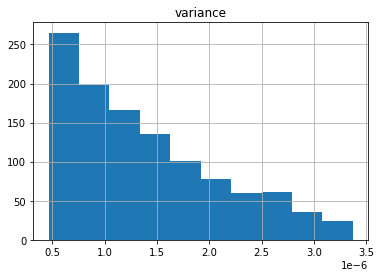

In [79]:
cov[['Symbol','variance']].drop_duplicates().hist()

In [80]:
cov_pivot = cov.pivot(index = 'Symbol', columns = 'DateTime', values = 'ret')
assert cov_pivot.shape[1] > cov_pivot.shape[0], 'Not enough data points to generate covariance matrix'
print(cov_pivot.shape)

(1124, 1921)


In [81]:
cov_pivot = cov.pivot(index = 'Symbol', columns = 'DateTime', values = 'ret')
cols = cov_pivot.index.tolist()
cov_mat = np.cov(cov_pivot)
cov_mat_df = pd.DataFrame(cov_mat, columns = cols, index = cols)

In [82]:
print(cov_mat.min(), cov_mat.max())

-7.946799941440427e-07 3.370337964612019e-06


In [83]:
# ledoit = LedoitWolf()
# ledoit.fit(cov_mat)
# ledoit_cov = ledoit.covariance_
# cov_df = pd.DataFrame(ledoit_cov, columns = cols, index = cols)
# cov_mat_df = cov_df

In [84]:
final_symbols = set(cov_mat_df.index.tolist()).intersection(returns.Symbol.tolist())

In [85]:
final_cov = cov_mat_df.loc[cov_mat_df.index.isin(final_symbols), final_symbols]
final_cov = final_cov.reindex(sorted(final_cov.columns), axis=1)

In [86]:
final_returns = returns[returns.Symbol.isin(final_symbols)]
final_returns.loc[:, 'all'] = 1

In [87]:
assert all([final_cov.columns[i] == final_cov.index.tolist()[i] for i in range(final_cov.shape[0])]), 'Columns and Index dont match'

In [88]:
print(final_cov.shape)
print(final_returns.shape)

(1124, 1124)
(1124, 7)


In [89]:
len(final_symbols)

1124

### Calculate Beta

In [90]:
snp_rets = client.get_dataframe('SPY',
                                              frequency='1Min',
                                              startDate=fivedaysbefore,
                                              endDate=today).reset_index().sort_values('date')

In [91]:
snp_rets['prev_close'] = snp_rets.close.shift(1)
snp_rets['ret'] = snp_rets['close'] / snp_rets['prev_close'] - 1

In [92]:
snp_rets = snp_rets[snp_rets.date.isin(cov_pivot.columns)]

In [93]:
y = snp_rets[['ret']]

In [94]:
from sklearn.linear_model import LinearRegression
betas = {}

for i in tqdm(list(final_symbols)):
    X = pd.DataFrame(cov_pivot.filter(like = i, axis = 0).values[0])
    lr = LinearRegression()
    lr.fit(X, y)
    betas[i] = lr.coef_[0][0]

100%|██████████| 1124/1124 [00:08<00:00, 140.36it/s]


In [95]:
final_returns['beta'] = final_returns['Symbol'].map(betas)

<AxesSubplot:>

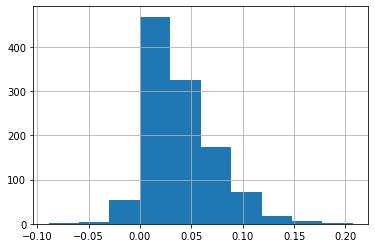

In [96]:
final_returns.beta.hist()

### Setting up Gurobi Model

In [97]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp

In [98]:
date = today
date_yesterday = yesterday
print(date, date_yesterday)

2021-05-26 2021-05-25


In [99]:
# Get Data
df_list = final_returns.values.tolist()

#Defining Dicts
stock, ret, al, b = gp.multidict((s, [ret, al, b]) for s, yc, tc, ret, fq, lq, al, b in df_list)

#Define Model
m = gp.Model('StatArb')

#Defining Variables
y = m.addVars(stock, name = 'weights')
Q = final_cov

Academic license - for non-commercial use only - expires 2021-06-22
Using license file C:\Users\amfaz\gurobi.lic


In [100]:
#Define Weights
weight_constrs = m.addConstr(y.prod(ret) == 1, 'define_weights')

z = m.addVar()
total_y = m.addConstr(z == y.sum(), 'total_y')

# Each weight have atleast 0.05
min_wt_constrs = {}
max_wt_constrs = {}
v = m.addVars(stock, vtype = GRB.BINARY, name = 'max_weight')
for s in stock:
    min_wt_constrs[s] = m.addConstr(y[s] >= 0.08 * z - 0.08 * z * v[s], 'min_wt')
    max_wt_constrs[s] = m.addConstr(y[s] <= 0.15 * z - 0.15 * z * v[s], 'max_wt')

# beta neutral
b_var = m.addVar()
b_var_abs = m.addVar()
bn = m.addConstr(b_var == y.prod(b), 'sum_of_betas')
bn_abs = m.addGenConstrAbs(b_var_abs, b_var)

In [101]:
#Objective Function
m.setObjective(Q.dot(pd.Series(y)).dot(pd.Series(y)) + b_var_abs, GRB.MINIMIZE)

In [102]:
m.setParam("Presolve", 0)
m.setParam("Aggregate", 0)
m.setParam("AggFill", 0)
m.setParam("PreSparsify", 0)
m.setParam("Threads", 3)
# m.setParam("MipGap", 1e-9)
# m.setParam("Cuts", 1)
m.setParam("TimeLimit", 1000)

m.optimize()

Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Aggregate to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter AggFill to 0
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter PreSparsify to 0
   Prev: -1  Min: -1  Max: 1  Default: -1
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter TimeLimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 3 threads
Optimize a model with 3 rows, 2251 columns and 3374 nonzeros
Model fingerprint: 0xe16b25c0
Model has 632250 quadratic objective terms
Model has 2248 quadratic constraints
Model has 1 general constraint
Variable types: 1127 continuous, 1124 integer (1124 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  QMatrix range    [8e-02, 1e-01

### Check Results

In [103]:
results = pd.concat([pd.Series(y.keys()), pd.Series([v.x for v in m.getVars()])], axis = 1).dropna()
results.columns = ['Stock','value']
results['weight'] = results[['value']].div(results[['value']].sum(axis=0),axis=1)
results = results[results.weight != 0]

In [104]:
final_results = final_returns[(final_returns.Symbol.isin(final_returns.Symbol))]
final_results = final_results.merge(results, left_on = 'Symbol', right_on = 'Stock')
final_results['weighted_rets'] = final_results['ret'] * final_results['weight']
assert abs(1 - final_results.weight.sum()) <= 0.01, 'Sum of Weight does not equal 1'

In [105]:
curr_cov = final_cov[final_cov.index.isin(results.Stock)][results.Stock].values.dot(results.weight).dot(results.weight)
curr_ret = final_results['weighted_rets'].sum()
print(curr_cov, curr_ret)

1.0829293443582196e-07 0.03424711315605217


In [106]:
out = final_results.merge(data[['Symbol','Security Name','ETF']], on = 'Symbol', how = 'left').sort_values('weight', ascending = False)
out['date'] = today
out

,Symbol,yesterday_close,today_close,ret,10thPerc,90thPerc,all,beta,Stock,value,weight,weighted_rets,Security Name,ETF,date
3,FN,85.590,87.540,0.022783,-0.00479,0.045829,1,-0.088953,FN,2.818374,0.096521,0.002199,Fabrinet Ordinary Shares,N,2021-05-26
11,VIACA,44.990,46.790,0.040009,-0.00479,0.045829,1,0.009827,VIACA,2.512170,0.086035,0.003442,ViacomCBS Inc. - Class A Common Stock,N,2021-05-26
2,FLO,24.110,24.190,0.003318,-0.00479,0.045829,1,-0.048381,FLO,2.496876,0.085511,0.000284,"Flowers Foods, Inc. Common Stock",N,2021-05-26
0,BMA,14.595,15.190,0.040767,-0.00479,0.045829,1,0.008195,BMA,2.463355,0.084363,0.003439,NaN,NaN,2021-05-26
8,PETS,27.825,28.960,0.040791,-0.00479,0.045829,1,0.027042,PETS,2.438433,0.083509,0.003406,"PetMed Express, Inc. - Common Stock",N,2021-05-26
7,NXGN,18.005,18.660,0.036379,-0.00479,0.045829,1,0.043303,NXGN,2.428146,0.083157,0.003025,"NextGen Healthcare, Inc. - Common Stock",N,2021-05-26
5,LILAK,14.065,14.585,0.036971,-0.00479,0.045829,1,-0.024479,LILAK,2.356522,0.080704,0.002984,Liberty Latin America Ltd. - Class C Common Stock,N,2021-05-26
6,MGPI,67.400,69.840,0.036202,-0.00479,0.045829,1,-0.010634,MGPI,2.341812,0.080200,0.002903,"MGP Ingredients, Inc. - Common Stock",N,2021-05-26
9,RLGY,18.510,19.270,0.041059,-0.00479,0.045829,1,0.049712,RLGY,2.335963,0.080000,0.003285,Realogy Holdings Corp. Common Stock,N,2021-05-26
1,CHX,24.920,25.920,0.040128,-0.00479,0.045829,1,0.044814,CHX,2.335963,0.080000,0.003210,ChampionX Corporation - Common Stock,N,2021-05-26


In [107]:
sum(out.beta * out.weight)

-1.6263032587282567e-18

### Validate Results

In [108]:
plot_ret = cov.loc[cov.Symbol.isin(final_results.Symbol),['Symbol','DateTime','ret']]
plot_ret['ret'] = plot_ret['ret'].cumsum()

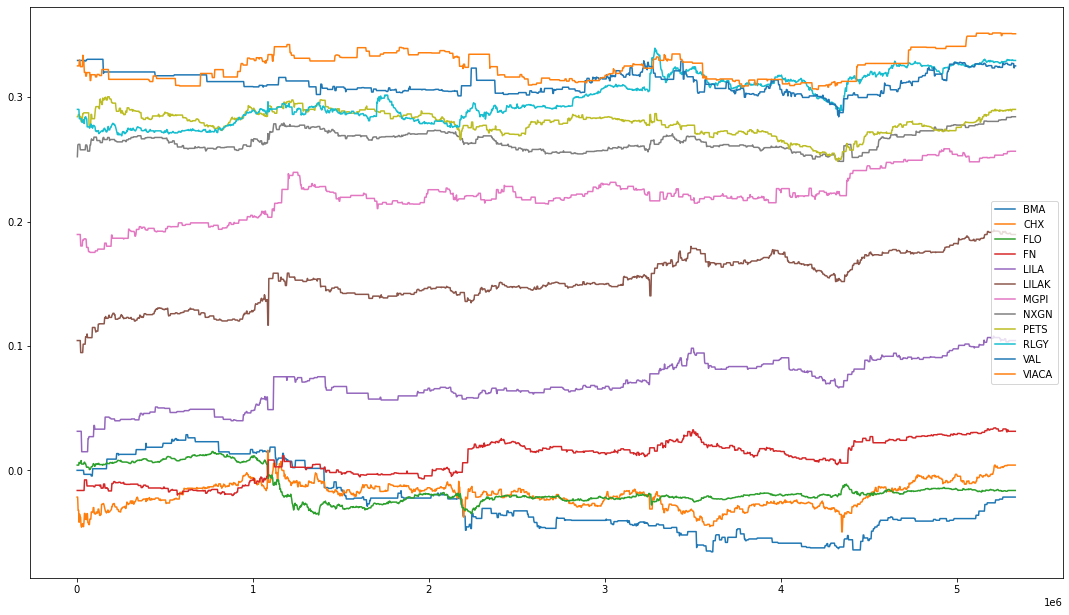

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for label, grp in plot_ret.groupby('Symbol')['ret']:
    grp.plot(x = grp.index, y = 'ret',ax = ax, label = label)
    
plt.legend()
# plt.xticks(rotation = 90)
fig.set_size_inches(18.5, 10.5)

In [110]:
cov.loc[cov.Symbol.isin(final_results.Symbol),['Symbol','variance','5thPerc','95thPerc']].drop_duplicates().sort_values('variance')

,Symbol,variance,5thPerc,95thPerc
3643,FLO,4.810539e-07,4.650196e-07,0.000003
4473,NXGN,6.155382e-07,4.650196e-07,0.000003
3655,FN,8.409940e-07,4.650196e-07,0.000003
4608,PETS,1.096615e-06,4.650196e-07,0.000003
5360,VIACA,1.217267e-06,4.650196e-07,0.000003
4259,MGPI,1.296532e-06,4.650196e-07,0.000003
4807,RLGY,1.309544e-06,4.650196e-07,0.000003
3091,BMA,1.338012e-06,4.650196e-07,0.000003
4131,LILA,1.391465e-06,4.650196e-07,0.000003
5338,VAL,1.506968e-06,4.650196e-07,0.000003


<AxesSubplot:>

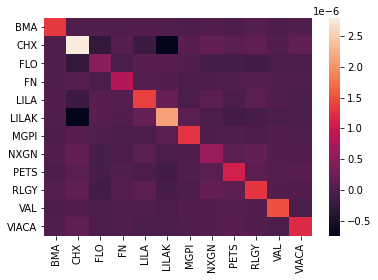

In [111]:
from seaborn import heatmap
heatmap(cov_mat_df.loc[cov_mat_df.index.isin(final_results.Symbol),final_results.Symbol])

In [112]:
data[data.Symbol.isin(final_results.Symbol)]

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
1837,Y,CHX,ChampionX Corporation - Common Stock,Q,Q,N,100.0,N,N,NaN,CHX,N
3604,Y,FLO,"Flowers Foods, Inc. Common Stock",N,,N,100.0,N,N,FLO,FLO,N
3666,Y,FN,Fabrinet Ordinary Shares,N,,N,100.0,N,N,FN,FN,N
5909,Y,LILA,Liberty Latin America Ltd. - Class A Common Stock,Q,Q,N,100.0,N,N,NaN,LILA,N
5910,Y,LILAK,Liberty Latin America Ltd. - Class C Common Stock,Q,Q,N,100.0,N,N,NaN,LILAK,N
6275,Y,MGPI,"MGP Ingredients, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,MGPI,N
7001,Y,NXGN,"NextGen Healthcare, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,NXGN,N
7437,Y,PETS,"PetMed Express, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,PETS,N
8239,Y,RLGY,Realogy Holdings Corp. Common Stock,N,,N,100.0,N,N,RLGY,RLGY,N
9973,Y,VAL,Valaris Limited Common Shares,N,,N,100.0,N,N,VAL,VAL,N


### Cancel Existing Orders

In [1]:
from webull import paper_webull # for paper trading, import 'paper_webull'

wb = paper_webull()
wb.login('your-email', 'password')

In [2]:
acc_details = wb.get_account()
acc_details

In [115]:
cancelbit = True
orders = wb.get_current_orders()

if cancelbit:
    for order in orders:
        ticker = order['ticker']['symbol']
        print(f'Cancelling order of {ticker}')
        if order['status'] == 'Working' :
            wb.cancel_order(order['orderId'])

#### Get LatestPrices as Market Might have Moved

In [116]:
buy_price = {}
for i in final_results.Symbol.tolist():
    try:
        buy_price[i] = wb.get_bars(i, extendTrading=1).close[0]
    except:
        print(f'Couldnt get price for {i}')

In [117]:
print(buy_price)

{'BMA': 15.19, 'CHX': 26.15, 'FLO': 24.17, 'FN': 87.63, 'LILA': 14.36, 'LILAK': 14.55, 'MGPI': 69.82, 'NXGN': 18.73, 'PETS': 29.09, 'RLGY': 19.34, 'VAL': 21.43, 'VIACA': 46.74}


In [118]:
if float(acc_details['netLiquidation']) >= 10000:
    money = float(acc_details['netLiquidation']) / 2 
else:
    money = 0.95 * float(acc_details['netLiquidation'])
print(money)

3315.4049999999997


In [119]:
final_results['allocated'] = final_results['weight'].values * float(money)
final_results['buy_units'] = final_results['allocated'] / final_results['today_close']
final_results['buy_units_int'] = final_results['buy_units'].astype(np.int)
buy_dict = final_results.set_index('Symbol').to_dict()['buy_units_int']

In [120]:
final_results

,Symbol,yesterday_close,today_close,ret,10thPerc,90thPerc,all,beta,Stock,value,weight,weighted_rets,allocated,buy_units,buy_units_int
0,BMA,14.595,15.190,0.040767,-0.00479,0.045829,1,0.008195,BMA,2.463355,0.084363,0.003439,279.696814,18.413220,18
1,CHX,24.920,25.920,0.040128,-0.00479,0.045829,1,0.044814,CHX,2.335963,0.080000,0.003210,265.232400,10.232731,10
2,FLO,24.110,24.190,0.003318,-0.00479,0.045829,1,-0.048381,FLO,2.496876,0.085511,0.000284,283.502955,11.719841,11
3,FN,85.590,87.540,0.022783,-0.00479,0.045829,1,-0.088953,FN,2.818374,0.096521,0.002199,320.006734,3.655549,3
4,LILA,13.870,14.395,0.037851,-0.00479,0.045829,1,0.000344,LILA,2.335963,0.080000,0.003028,265.232400,18.425314,18
5,LILAK,14.065,14.585,0.036971,-0.00479,0.045829,1,-0.024479,LILAK,2.356522,0.080704,0.002984,267.566679,18.345333,18
6,MGPI,67.400,69.840,0.036202,-0.00479,0.045829,1,-0.010634,MGPI,2.341812,0.080200,0.002903,265.896492,3.807224,3
7,NXGN,18.005,18.660,0.036379,-0.00479,0.045829,1,0.043303,NXGN,2.428146,0.083157,0.003025,275.699150,14.774874,14
8,PETS,27.825,28.960,0.040791,-0.00479,0.045829,1,0.027042,PETS,2.438433,0.083509,0.003406,276.867120,9.560329,9
9,RLGY,18.510,19.270,0.041059,-0.00479,0.045829,1,0.049712,RLGY,2.335963,0.080000,0.003285,265.232400,13.764006,13


In [121]:
total_needed = sum([buy_price[i] * buy_dict[i] for i in buy_price.keys()])
total_needed

3106.57

## Adjust Current Positions

In [122]:
positions = wb.get_positions()

In [123]:
curr_positions = {i['ticker']['symbol']: i['position'] for i in positions}

In [124]:
curr_positions

{'LILA': '18',
 'SHG': '13',
 'TLK': '15',
 'VICR': '2',
 'SPKE': '28',
 'SAND': '31',
 'UEPS': '52',
 'BSTZ': '7',
 'ACH': '18',
 'HLNE': '2',
 'FN': '3'}

#### At Market

In [125]:
if datetime.datetime.now().time() < market_close_time:
    for i in buy_dict.keys():
        if i in curr_positions:
            new_position = buy_dict[i]
            old_position = curr_positions[i]
            diff = int(new_position) - int(old_position)
            if diff > 0:
                print(f'Position for {i} already exists - Buying additional {diff} units of {i} at Market')
                wb.place_order(i, orderType = 'MKT', quant = diff, enforce = 'DAY')
            elif diff < 0:
                print(f'Position for {i} already exists - Selling additional {abs(diff)} units of {i} at Market')
                wb.place_order(i, action = 'SELL', orderType = 'MKT', quant = abs(diff), enforce = 'DAY')
            else:
                print(f'Position for {i} already exists - Already have {new_position} units -  No order required for this ticker')

Position for FN already exists - Already have 3 units -  No order required for this ticker
Position for LILA already exists - Already have 18 units -  No order required for this ticker


#### At Limit, if Market is Closed

In [126]:
if datetime.datetime.now().time() > market_close_time:
    for i in buy_dict.keys():
        if i in curr_positions:
            new_position = buy_dict[i]
            old_position = curr_positions[i]
            diff = int(new_position) - int(old_position)
            if diff > 0:
                print(f'Position for {i} already exists - Buying additional {diff} units of {i} at Limit Price of {buy_price[i]}')
                wb.place_order(i, price = buy_price[i], quant = diff)
            elif diff < 0:
                print(f'Position for {i} already exists - Selling additional {abs(diff)} units of {i} at Limit Price of {buy_price[i]}')
                wb.place_order(i, action = 'SELL', price = buy_price[i], quant = abs(diff))
            else:
                print(f'Position for {i} already exists - Already have {new_position} units - No order required for this ticker')

### Sell Old Position Not Needed

In [128]:
sell_position = True
positions = wb.get_positions()
Limit = False

if sell_position:
    for position in positions:
        ticker = position['ticker']['symbol']
        if (ticker not in buy_dict.keys() and ticker in curr_positions.keys()):
            lastPrice = position['lastPrice']
            qty = position['position']
            if datetime.datetime.now().time() < market_close_time:
                print(f'Selling Position of {ticker} at Market Price {lastPrice} with {qty} quantity')
                wb.place_order(ticker, action = 'SELL', orderType = 'MKT', quant = position['position'], enforce = 'DAY')
            else:
                print(f'Market Closed. Selling position of {ticker} at LastPrice Price {lastPrice} with {qty} quantity')
                wb.place_order(ticker, action = 'SELL', price = position['lastPrice'], orderType = 'LMT', enforce = 'GTC', quant = position['position'])

Selling Position of SHG at Market Price 37.34 with 13 quantity
Selling Position of TLK at Market Price 23.18 with 15 quantity
Selling Position of VICR at Market Price 88.80 with 2 quantity
Selling Position of SPKE at Market Price 10.99 with 28 quantity
Selling Position of SAND at Market Price 8.46 with 31 quantity
Selling Position of UEPS at Market Price 5.00 with 52 quantity
Selling Position of BSTZ at Market Price 36.69 with 7 quantity
Selling Position of ACH at Market Price 13.91 with 18 quantity
Selling Position of HLNE at Market Price 93.61 with 2 quantity


In [129]:
import time
time.sleep(5)

### Buy New Positions

In [130]:
for i in buy_dict.keys():
    if i not in curr_positions.keys():
        if (datetime.datetime.now().time() < market_close_time and datetime.datetime.now().date() == today):
            print(f'Market Order - Buying {buy_dict[i]} units of {i} at {buy_price[i]}')
            wb.place_order(i, orderType = 'MKT', quant = buy_dict[i], enforce = 'DAY')
        else:
            print(f'Limit Order - Buying {buy_dict[i]} units of {i} at {buy_price[i]}')
            wb.place_order(i, price = buy_price[i], quant = buy_dict[i])
        time.sleep(1)

Market Order - Buying 18 units of BMA at 15.19
Market Order - Buying 10 units of CHX at 26.15
Market Order - Buying 11 units of FLO at 24.17
Market Order - Buying 18 units of LILAK at 14.55
Market Order - Buying 3 units of MGPI at 69.82
Market Order - Buying 14 units of NXGN at 18.73
Market Order - Buying 9 units of PETS at 29.09
Market Order - Buying 13 units of RLGY at 19.34
Market Order - Buying 12 units of VAL at 21.43
Market Order - Buying 6 units of VIACA at 46.74


### Check if orders tie out

In [131]:
orders = wb.get_current_orders()
order_list = {i['ticker']['symbol']: i['totalQuantity'] for i in orders}
order_list

{'VIACA': '6',
 'MGPI': '3',
 'LILAK': '18',
 'ACH': '18',
 'BSTZ': '7',
 'UEPS': '52'}

In [132]:
time.sleep(2)

In [133]:
positions = wb.get_positions()
curr_positions = {i['ticker']['symbol']: i['position'] for i in positions}

In [134]:
tie_pos = {}
for i in final_results.Symbol:
    tie_pos[i] = int(order_list.get(i, 0)) + int(curr_positions.get(i, 0))
tie_pos

{'BMA': 18,
 'CHX': 10,
 'FLO': 11,
 'FN': 3,
 'LILA': 18,
 'LILAK': 18,
 'MGPI': 3,
 'NXGN': 0,
 'PETS': 0,
 'RLGY': 0,
 'VAL': 0,
 'VIACA': 6}

In [135]:
match = {}
for i in final_results.Symbol:
    if buy_dict[i] == tie_pos[i]:
        match[i] = True
    else:
        match[i] = False

In [136]:
match

{'BMA': True,
 'CHX': True,
 'FLO': True,
 'FN': True,
 'LILA': True,
 'LILAK': True,
 'MGPI': True,
 'NXGN': False,
 'PETS': False,
 'RLGY': False,
 'VAL': False,
 'VIACA': True}